In [1]:
import torch  
from torch import nn
import numpy as np 
from torch_snippets import show
from torchvision.models import resnet50, ResNet50_Weights
from torchinfo import summary
import requests
from PIL import Image
from torchvision import transforms as T
from torch.nn import functional as F


In [2]:

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)


for param in model.parameters():
    param.requires_grad = False


In [3]:
summary(model)


Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  (4,096)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─Conv2d: 3-3                  (36,864)
│    │    └─BatchNorm2d: 3-4             (128)
│    │    └─Conv2d: 3-5                  (16,384)
│    │    └─BatchNorm2d: 3-6             (512)
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              (16,896)
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  (16,384)
│    │    └─BatchNorm2d: 3-10            (128)
│    │    └─Conv2d: 3-11                 (36,864)
│    │    └─BatchNorm2d: 3-12            (128)
│    │    └─C

In [4]:
img_net_1k = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
img_net_1k = requests.get(img_net_1k).text
img_net_1k_ids = eval(img_net_1k) 
img_net_1k_classes = {i:j for (j,i) in img_net_1k_ids.items()}
img_net_1k_classes['strawberry']


949

In [5]:

url = 'https://clv.h-cdn.co/assets/15/22/2560x1280/landscape-1432664914-strawberry-facts1.jpg'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    with open('./images/img_2.jpg', 'wb') as file:
        file.write(response.content)
    print("Image downloaded successfully.")
else:
    print(f"Failed to download image. Status code: {response.status_code}")


Image downloaded successfully.


In [5]:
def resize(input_path, output_path, height, width):
    
    image = Image.open(input_path)

    image = image.resize((width, height))

    image.save(output_path, format=image.format)


In [6]:
resize("./images/img_2.jpg","./images/img_2.jpg",515,512)


In [7]:
img = Image.open('./images/img_2.jpg').convert('RGB')
imgNp = np.array(img)
imgTensor = torch.tensor(imgNp)
imgTensor.shape


torch.Size([515, 512, 3])

In [8]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
denormalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                        std=[1/0.229, 1/0.224, 1/0.225])

def imageToTensor(img):
    imageNp = np.array(img)
    imgTensor = torch.tensor(imageNp).permute(2, 0, 1)
    normalized_img = normalize( imgTensor / 255.)
    return normalized_img

def tensorToImage(inputTensor):
    inputTensor = denormalize(inputTensor).permute(1,2,0)
    inputTensor = inputTensor * 255 
    inputTensor = inputTensor.to(torch.uint8)
    return inputTensor


In [9]:
f = imageToTensor(img)
c = tensorToImage(f)


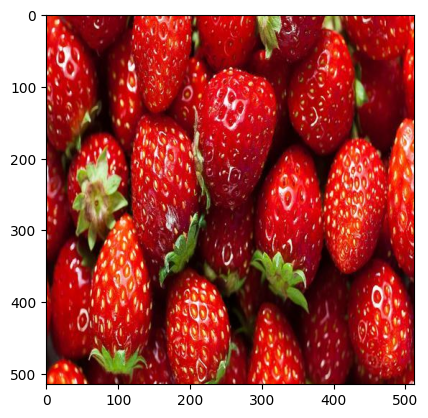

In [10]:
import matplotlib.pyplot as plt
c
plt.imshow(c)


In [11]:
def predictOnImage(input):
    model.eval()
    show(input)
    input = imageToTensor(input).unsqueeze(dim=0)
    pred = model(input)
    pred = F.softmax(pred, dim=-1)[0]
    prob, clss = torch.max(pred, 0)
    clss = img_net_1k_ids[int(clss)]
    print(f'PREDICTION: `{clss}` P : {int(prob.item()*100)}%')


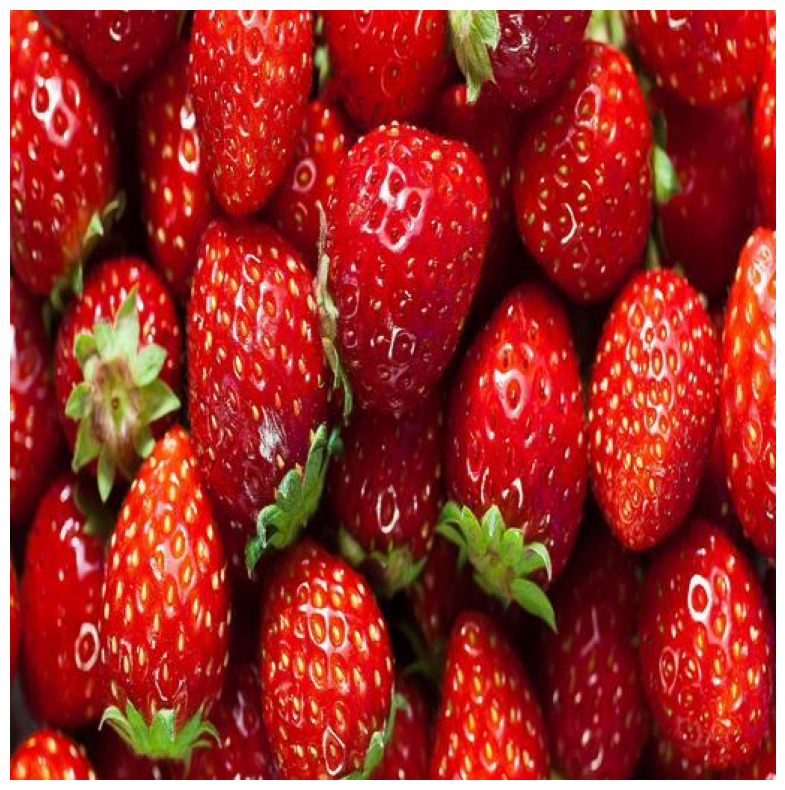

PREDICTION: `strawberry` P : 99%


In [12]:
predictOnImage(img)


In [14]:
losses = []
def Attacker(image,model,target,epislon=1e-6):
    input = imageToTensor(image).unsqueeze(dim=0)

    input.requires_grad = True
    
    pred = model(input)

    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(pred, target)

    loss.backward()

    losses.append(loss.mean().item())

    output = input - epislon * input.grad.sign()
    
    output = tensorToImage(output.squeeze(dim=0))
    return output.detach() # lets detach it from cimputation graph


In [15]:
modifiedImages = []
desireTargets = ['lemon','comic book','sax, saxophone']


In [16]:
from tqdm import trange
for target in desireTargets:
    target = torch.tensor([img_net_1k_classes[target]])
    imageToAttack = img
    for _ in trange(10):
        imageToAttack = Attacker(imageToAttack,model,target)
    modifiedImages.append(imageToAttack)


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


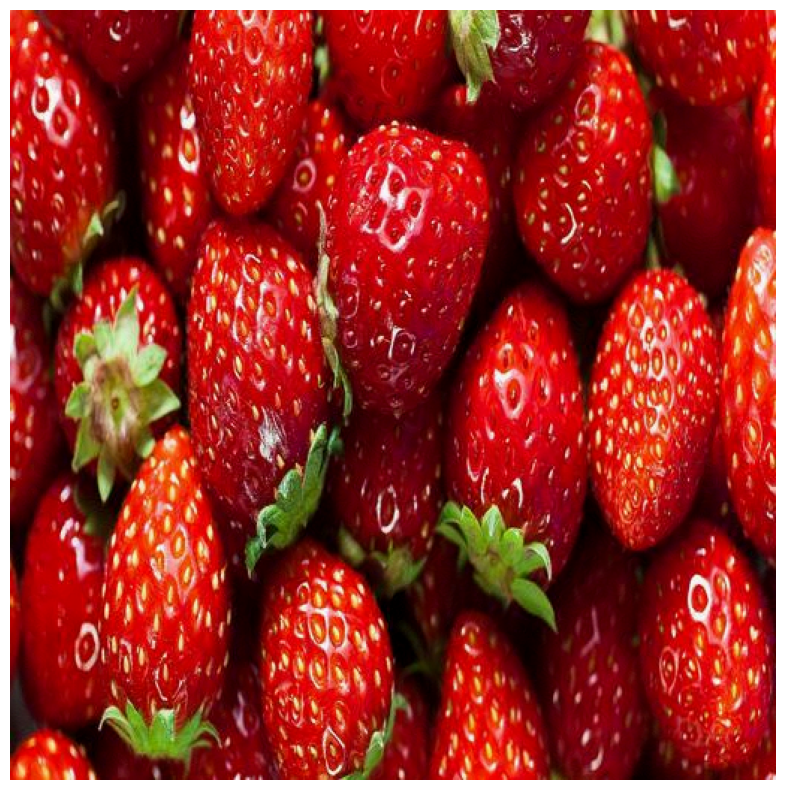

PREDICTION: `lemon` P : 97%


In [20]:
predictOnImage(modifiedImages[0])
